## Delaunay Triangulation 
### Algorithm Name: Divide And Conquer Algorithm


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from typing import List, Tuple, Optional, Set
import time

### Algorithm Implementation

In [92]:
"""

The divide-and-conquer algorithm for computing Delaunay triangulation of a set of points.

"""


edges = [] # container for edges

def delaunay_triangulation(S):
    """Assumes S is a list of points of form (x, y).
    Returns a list of edges that form a Delaunay triangulation of S."""

    if len(S) < 2:
        print("Must be at least two points.")
        return
    
    global edges
    edges = []
    S = np.asarray(S, dtype=np.float64)
    
    # Sort points by x coordinate, y is a tiebreaker.
    S.view(dtype=[('f0', S.dtype), ('f1', S.dtype)]).sort(order=['f0', 'f1'], axis=0)
    
    # Remove duplicates.
    dupes = [i for i in range(1, len(S)) if S[i-1][0] == S[i][0] and S[i-1][1] == S[i][1]]
    if dupes:
        S = np.delete(S, dupes, 0)

    triangulate(S)
    edges = [e for e in edges if e.data is None]  # clean the garbage

    return edges


# -----------------------------------------------------------------
# Quad edge data structure.


class Edge:
    """A directed edge: org -> dest.
    When traversing edge ring: Next is CCW, Prev is CW."""

    def __init__(self, org, dest):
        self.org   = org
        self.dest  = dest
        self.onext = None
        self.oprev = None
        self.sym   = None    # symmetrical counterpart of this edge
        self.data  = None  

    def __str__(self):
        s = str(self.org) + ', ' + str(self.dest)
        if self.data is None:
            return s
        else:
            return s + ' ' + str(self.data)


def triangulate(S):
    """Computes the Delaunay triangulation of a point set S and returns two edges, le and re,
    which are the counterclockwise convex hull edge out of the leftmost vertex and the clockwise
    convex hull edge out of the rightmost vertex, respectively."""

    if len(S) == 2:
        a = make_edge(S[0], S[1])
        return a, a.sym

    elif len(S) == 3:
        # Create edges a connecting p1 to p2 and b connecting p2 to p3.
        p1, p2, p3 = S[0], S[1], S[2]
        a = make_edge(p1, p2)
        b = make_edge(p2, p3)
        splice(a.sym, b)

        # Close the triangle.
        if right_of(p3, a):
            connect(b, a)
            return a, b.sym
        elif left_of(p3, a):
            c = connect(b, a)
            return c.sym, c
        else:  # the three points are collinear
            return a, b.sym

    else:
        # Recursively subdivide S.
        m = (len(S) + 1) // 2
        L, R = S[:m], S[m:]
        ldo, ldi = triangulate(L)
        rdi, rdo = triangulate(R)

        # Compute the upper common tangent of L and R.
        while True:
            if right_of(rdi.org, ldi):
                ldi = ldi.sym.onext
            elif left_of(ldi.org, rdi):
                rdi = rdi.sym.oprev
            else:
                break

        # Create a first cross edge base from rdi.org to ldi.org.
        base = connect(ldi.sym, rdi)

        # Adjust ldo and rdo
        if ldi.org[0] == ldo.org[0] and ldi.org[1] == ldo.org[1]:
            ldo = base
        if rdi.org[0] == rdo.org[0] and rdi.org[1] == rdo.org[1]:
            rdo = base.sym

        # Merge.
        while True:
            # Locate the first R and L points to be encountered by the diving bubble.
            rcand, lcand = base.sym.onext, base.oprev
            # If both lcand and rcand are invalid, then base is the lower common tangent.
            v_rcand, v_lcand = right_of(rcand.dest, base), right_of(lcand.dest, base)
            if not (v_rcand or v_lcand):
                break
            # Delete R edges out of base.dest that fail the circle test.
            if v_rcand:
                while right_of(rcand.onext.dest, base) and \
                      in_circle(base.dest, base.org, rcand.dest, rcand.onext.dest) == 1:
                    t = rcand.onext
                    delete_edge(rcand)
                    rcand = t
            # Symmetrically, delete L edges.
            if v_lcand:
                while right_of(lcand.oprev.dest, base) and \
                      in_circle(base.dest, base.org, lcand.dest, lcand.oprev.dest) == 1:
                    t = lcand.oprev
                    delete_edge(lcand)
                    lcand = t
            # The next cross edge is to be connected to either lcand.dest or rcand.dest.
            # If both are valid, then choose the appropriate one using the in_circle test.
            if not v_rcand or \
               (v_lcand and in_circle(rcand.dest, rcand.org, lcand.org, lcand.dest) == 1):
                # Add cross edge base from rcand.dest to base.dest.
                base = connect(lcand, base.sym)
            else:
                # Add cross edge base from base.org to lcand.dest
                base = connect(base.sym, rcand.sym)

        return ldo, rdo


# -----------------------------------------------------------------
# Predicates


def in_circle(a, b, c, d):
    """Does d lie inside of circumcircle abc?"""
    a1, a2 = a[0]-d[0], a[1]-d[1]
    b1, b2 = b[0]-d[0], b[1]-d[1]
    c1, c2 = c[0]-d[0], c[1]-d[1]
    a3, b3, c3 = a1**2 + a2**2, b1**2 + b2**2, c1**2 + c2**2
    det = a1*b2*c3 + a2*b3*c1 + a3*b1*c2 - (a3*b2*c1 + a1*b3*c2 + a2*b1*c3)
    return det < 0


def right_of(p, e):
    """Does point p lie to the right of the line of edge e?"""
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det > 0


def left_of(p, e):
    """Does point p lie to the left of the line of edge e?"""
    a, b = e.org, e.dest
    det = (a[0]-p[0]) * (b[1]-p[1]) - (a[1]-p[1]) * (b[0]-p[0])
    return det < 0


# -----------------------------------------------------------------
# Topological operators


def make_edge(org, dest):
    """Creates a new edge. Assumes org and dest are points."""

    global edges
    e  = Edge(org, dest)
    es = Edge(dest, org)
    e.sym, es.sym = es, e  # make edges mutually symmetrical
    e.onext, e.oprev = e, e
    es.onext, es.oprev = es, es
    edges.append(e)
    return e


def splice(a, b):
    """Combines distinct edge rings / breaks the same ring in two pieces. Merging / tearing goes
    between a and a.onext through a.org to between b and b.onext."""

    if a == b:
        print("Splicing edge with itself, ignored: {}.".format(a))
        return

    a.onext.oprev, b.onext.oprev = b, a
    a.onext, b.onext = b.onext, a.onext


def connect(a, b):
    """Adds a new edge e connecting the destination of a to the origin of b, in such a way that
    a Left = e Left = b Left after the connection is complete."""
    e = make_edge(a.dest, b.org)
    splice(e, a.sym.oprev)
    splice(e.sym, b)
    return e


def delete_edge(e):
    """Disconnects the edge e from the rest of the structure (this may cause the rest of the
    structure to fall apart in two separate components)."""
    splice(e, e.oprev)
    splice(e.sym, e.sym.oprev)
    e.data, e.sym.data = True, True


def edges_to_triangles(points, edges):
    """
    points: list of (x, y)
    edges: list of QuadEdge objects with e.org, e.dest as np.arrays

    returns: set of sorted triangle index triples
    """
    # Map coordinates to original point indices
    point_to_idx = {tuple(p): i for i, p in enumerate(points)}

    # Build adjacency
    adj = {i: set() for i in range(len(points))}

    for e in edges:
        a = point_to_idx[tuple(e.org)]
        b = point_to_idx[tuple(e.dest)]
        adj[a].add(b)
        adj[b].add(a)

    triangles = set()

    # Check neighbors for triangles
    for p in range(len(points)):
        nbrs = list(adj[p])
        L = len(nbrs)
        for i in range(L):
            u = nbrs[i]
            for j in range(i + 1, L):
                v = nbrs[j]
                # triangle exists if u-v is also an edge
                if u in adj[v]:
                    tri = tuple(sorted((p, u, v)))
                    triangles.add(tri)

    return triangles


Dataset Generation 

In [ ]:
# Generate Dataset points

def generate_random_points(n_points=50, x_range=(0, 1), y_range=(0, 1), seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    
    points = np.column_stack((x, y))
    return points

def generate_gaussian_points(n_points=50, mean=(0.5, 0.5), cov=None, seed=None):
    """2D Gaussian distributed points."""
    if seed is not None:
        np.random.seed(seed)
    if cov is None:
        cov = [[0.02, 0.0], [0.0, 0.02]]  # isotropic default covariance
    points = np.random.multivariate_normal(mean, cov, n_points)
    return np.clip(points, 0, 1)  # keep in [0,1] range


def generate_poisson_disc_points(radius=0.2, x_range=(0, 1), y_range=(0, 1), k=30, seed=None):
    """
    Poisson disk sampling (Blue noise).
    - radius: minimum distance between points.
    - k: number of candidates per active point.
    """
    if seed is not None:
        np.random.seed(seed)

    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    cell_size = radius / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)
    points = []
    active_list = []

    def in_bounds(p):
        return x_range[0] <= p[0] <= x_range[1] and y_range[0] <= p[1] <= y_range[1]

    def grid_coords(p):
        return int((p[0] - x_range[0]) / cell_size), int((p[1] - y_range[0]) / cell_size)

    def too_close(p):
        gx, gy = grid_coords(p)
        for i in range(max(gy - 2, 0), min(gy + 3, grid_h)):
            for j in range(max(gx - 2, 0), min(gx + 3, grid_w)):
                idx = grid[i, j]
                if idx != -1:
                    dist = np.linalg.norm(points[idx] - p)
                    if dist < radius:
                        return True
        return False

    # Initial point
    first_point = np.array([
        np.random.uniform(x_range[0], x_range[1]),
        np.random.uniform(y_range[0], y_range[1])
    ])
    points.append(first_point)
    active_list.append(0)
    gx, gy = grid_coords(first_point)
    grid[gy, gx] = 0

    while active_list:
        idx = np.random.choice(active_list)
        base_point = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(radius, 2 * radius)
            new_point = base_point + np.array([r * np.cos(theta), r * np.sin(theta)])
            if in_bounds(new_point) and not too_close(new_point):
                points.append(new_point)
                gx, gy = grid_coords(new_point)
                grid[gy, gx] = len(points) - 1
                active_list.append(len(points) - 1)
                found = True
                break
        if not found:
            active_list.remove(idx)
    return np.array(points)


def generate_clustered_points(n_points=100, n_clusters=3, x_range=(0, 1), y_range=(0, 1), seed=None):
    """Multiple dense clusters with sparse regions between them."""
    if seed is not None:
        np.random.seed(seed)
    cluster_centers = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]], (n_clusters, 2))
    points_per_cluster = n_points // n_clusters
    remainder = n_points % n_clusters
    points = []
    for i, center in enumerate(cluster_centers):
        size = points_per_cluster + (1 if i < remainder else 0)
        cov = np.diag(np.random.uniform(0.001, 0.01, 2))
        cluster = np.random.multivariate_normal(center, cov, size)
        points.append(cluster)
    return np.clip(np.vstack(points), 0, 1)

### Comparative Analysis amongst different types of datasets

Running for n=100...
Running for n=200...
Running for n=300...
Running for n=400...
Running for n=500...
Running for n=600...
Running for n=700...
Running for n=800...
Running for n=900...
Running for n=1000...
Running for n=1100...
Running for n=1200...
Running for n=1300...
Running for n=1400...
Running for n=1500...
Running for n=1600...
Running for n=1700...
Running for n=1800...
Running for n=1900...
Running for n=2000...
Running for n=2100...
Running for n=2200...
Running for n=2300...
Running for n=2400...
Running for n=2500...
Running for n=2600...
Running for n=2700...
Running for n=2800...
Running for n=2900...
Running for n=3000...
Running for n=3100...
Running for n=3200...
Running for n=3300...
Running for n=3400...
Running for n=3500...
Running for n=3600...
Running for n=3700...
Running for n=3800...
Running for n=3900...
Running for n=4000...
Running for n=4100...
Running for n=4200...
Running for n=4300...
Running for n=4400...
Running for n=4500...
Running for n=4600.

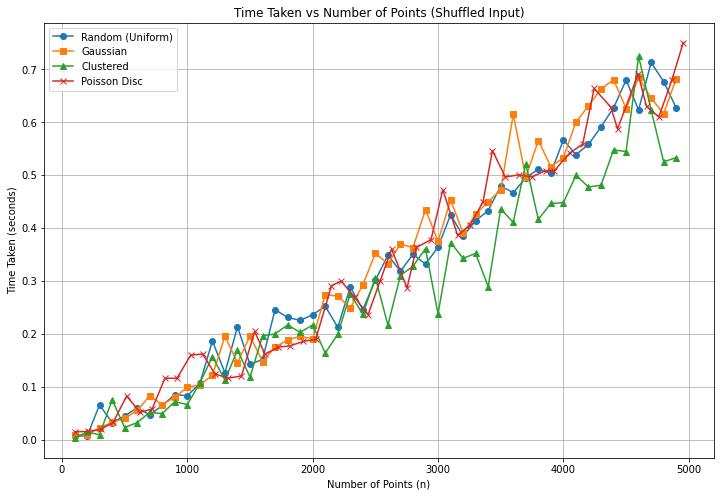

In [88]:
import time
import matplotlib.pyplot as plt
import numpy as np

ns = [i for i in range(100, 5000, 100)]

results = {
    "Random": [],
    "Gaussian": [],
    "Clustered": [],
    "Poisson": []
}

for n in ns:
    print(f"Running for n={n}...")
    
    # Random
    pts = generate_random_points(n_points=n, seed=10)
    np.random.shuffle(pts)
    start_time = time.time()
    pts1 = delaunay_triangulation(pts)
    end_time = time.time()
    # pts2 = Delaunay(points=pts).simplices
    # if len(pts1) != len(pts2): 
    #     print(f"The implementation differs at {len(pts)} Random points by {len(pts1)} / {len(pts2)}.")
    #     print(f"--------------- Divide and conquer -----------")
    #     print(pts1)
    #     print(f"---------------- Scipy Delaunay ------------")
    #     print(pts2)
    results["Random"].append(end_time - start_time)
    
    # Gaussian
    pts = generate_gaussian_points(n_points=n, seed=42)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    pts1 = delaunay_triangulation(pts)
    end_time = time.time()
    
    results["Gaussian"].append(end_time - start_time)
    
    # Clustered
    pts = generate_clustered_points(n_points=n, seed=52)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    pts1 = delaunay_triangulation(pts)
    end_time = time.time()
    
    results["Clustered"].append(end_time - start_time)
    
    # Poisson
    r = np.sqrt(0.625 / n) 
    pts = generate_poisson_disc_points(radius=r, seed=62)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    pts1 = delaunay_triangulation(pts)
    end_time = time.time()
    
    results["Poisson"].append((len(pts), end_time - start_time))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(ns, results["Random"], label="Random (Uniform)", marker='o')
plt.plot(ns, results["Gaussian"], label="Gaussian", marker='s')
plt.plot(ns, results["Clustered"], label="Clustered", marker='^')

# Poisson scatter/line
p_ns = [x[0] for x in results["Poisson"]]
p_times = [x[1] for x in results["Poisson"]]

# Sort by n (just in case)
p_sorted = sorted(zip(p_ns, p_times))
p_ns = [x[0] for x in p_sorted]
p_times = [x[1] for x in p_sorted]

plt.plot(p_ns, p_times, label="Poisson Disc", marker='x')

plt.xlabel("Number of Points (n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken vs Number of Points (Shuffled Input)")
plt.legend()
plt.grid(True)
plt.show()

### Empirical Time complexity analysis

Running for n=1000...
Running for n=1500...
Running for n=2000...
Running for n=2500...
Running for n=3000...
Running for n=3500...
Running for n=4000...
Running for n=4500...
Running for n=5000...
Running for n=5500...
Running for n=6000...
Running for n=6500...
Running for n=7000...
Running for n=7500...
Running for n=8000...
Running for n=8500...
Running for n=9000...
Running for n=9500...


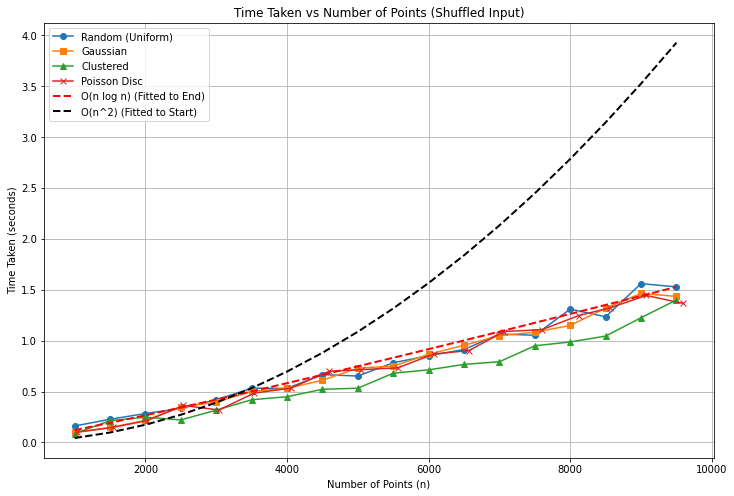

In [98]:
import time
import matplotlib.pyplot as plt
import numpy as np

ns = [i for i in range(1000, 10000, 500)]

results = {
    "Random": [],
    "Gaussian": [],
    "Clustered": [],
    "Poisson": []
}

for n in ns:
    print(f"Running for n={n}...")
    
    # Random
    pts = generate_random_points(n_points=n, seed=10)
    np.random.shuffle(pts)
    start_time = time.time()
    delaunay_triangulation(pts)
    end_time = time.time()
    results["Random"].append(end_time - start_time)
    
    # Gaussian
    pts = generate_gaussian_points(n_points=n, seed=42)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    delaunay_triangulation(pts)
    end_time = time.time()
    results["Gaussian"].append(end_time - start_time)
    
    # Clustered
    pts = generate_clustered_points(n_points=n, seed=52)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    delaunay_triangulation(pts)
    end_time = time.time()
    results["Clustered"].append(end_time - start_time)
    
    # Poisson
    r = np.sqrt(0.625 / n) 
    pts = generate_poisson_disc_points(radius=r, seed=62)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    delaunay_triangulation(pts)
    end_time = time.time()
    results["Poisson"].append((len(pts), end_time - start_time))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(ns, results["Random"], label="Random (Uniform)", marker='o')
plt.plot(ns, results["Gaussian"], label="Gaussian", marker='s')
plt.plot(ns, results["Clustered"], label="Clustered", marker='^')

# Poisson scatter/line
p_ns = [x[0] for x in results["Poisson"]]
p_times = [x[1] for x in results["Poisson"]]

# Sort by n (just in case)
p_sorted = sorted(zip(p_ns, p_times))
p_ns = [x[0] for x in p_sorted]
p_times = [x[1] for x in p_sorted]

plt.plot(p_ns, p_times, label="Poisson Disc", marker='x')

# Theoretical Lines
ns_arr = np.array(ns)

# Use the maximum time from Random as a reference for scaling
# We use the last point to anchor the theoretical curves
if results["Random"]:
    # 1. Fit O(n log n) to the LAST point (Max N)
    # This checks: "Does my data follow this shape?"
    ref_n_last = ns[-1]
    ref_time_last = results["Random"][-1]
    
    k_log = ref_time_last / (ref_n_last * np.log(ref_n_last))
    plt.plot(ns, k_log * (ns_arr * np.log(ns_arr)), 'r--', label="O(n log n) (Fitted to End)", linewidth=2)

    # 2. Fit O(n^2) to an EARLY point (e.g., the 5th point)
    # This checks: "If this were quadratic, where would it be by now?"
    # We skip index 0-4 to avoid initial startup noise/caching jitter
    ref_idx = 5 
    if len(ns) > ref_idx:
        ref_n_early = ns[ref_idx]
        ref_time_early = results["Random"][ref_idx]
        k2 = ref_time_early / (ref_n_early**2)
        plt.plot(ns, k2 * (ns_arr**2), 'k--', label="O(n^2) (Fitted to Start)", linewidth=2)

plt.xlabel("Number of Points (n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken vs Number of Points (Shuffled Input)")
plt.legend()
plt.grid(True)
plt.show()

## Plotting the output




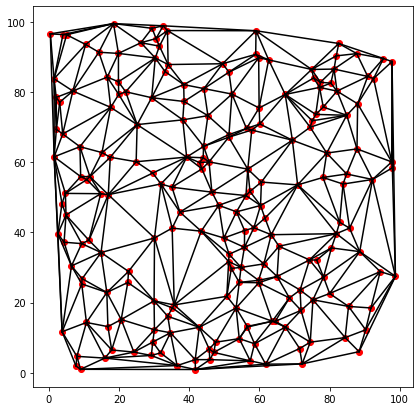

In [89]:
def plot_triangulation_edges(
    points = generate_random_points(200, x_range=(0,100), y_range=(0,100), seed=10),
    triangulator = delaunay_triangulation
):
    """
    Plot edges from a triangulator(points) where each edge has:
        e.org  = np.array([x, y])
        e.dest = np.array([x, y])
    """

    # SciPy branch (optional)
    if triangulator == Delaunay:
        pts = np.array(points)
        tri = Delaunay(pts)

        edges = set()
        for a, b, c in tri.simplices:
            edges.add(tuple(sorted((a, b))))
            edges.add(tuple(sorted((b, c))))
            edges.add(tuple(sorted((c, a))))

        plt.figure(figsize=(7, 7))
        for i, j in edges:
            x1, y1 = pts[i]
            x2, y2 = pts[j]
            plt.plot([x1, x2], [y1, y2], color="black")

        plt.scatter(pts[:,0], pts[:,1], color="red")
        plt.gca().set_aspect("equal")
        plt.show()
        return


    edges = triangulator(points)   

    plt.figure(figsize=(7, 7))

    seen = set()  # avoid plotting duplicates

    for e in edges:
        a = tuple(e.org)   # (x, y)
        b = tuple(e.dest)  # (x, y)

        if a == b:
            continue

        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)

        x1, y1 = a
        x2, y2 = b
        plt.plot([x1, x2], [y1, y2], color="black")

    # scatter the original points (optional)
    xs, ys = zip(*points)
    plt.scatter(xs, ys, color="red")

    plt.gca().set_aspect("equal")
    plt.show()

plot_triangulation_edges(triangulator=delaunay_triangulation)

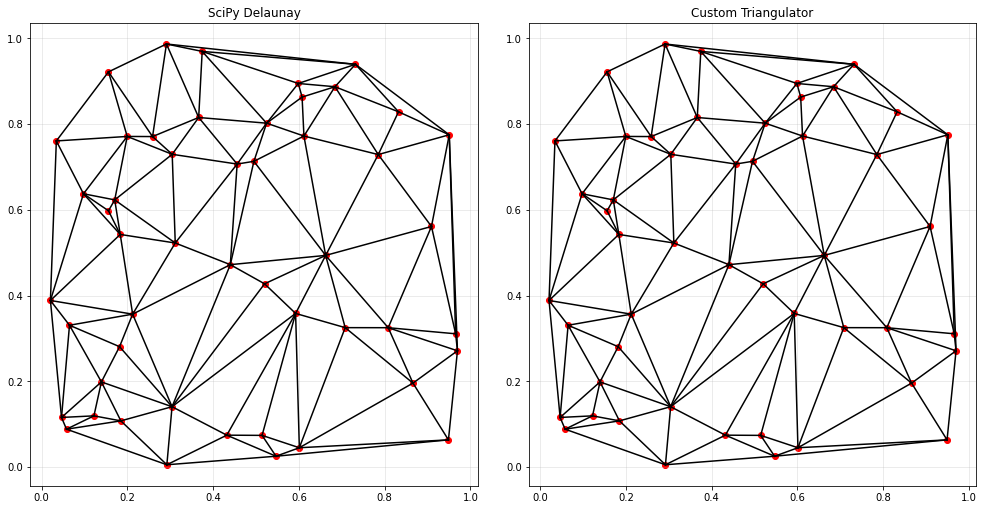

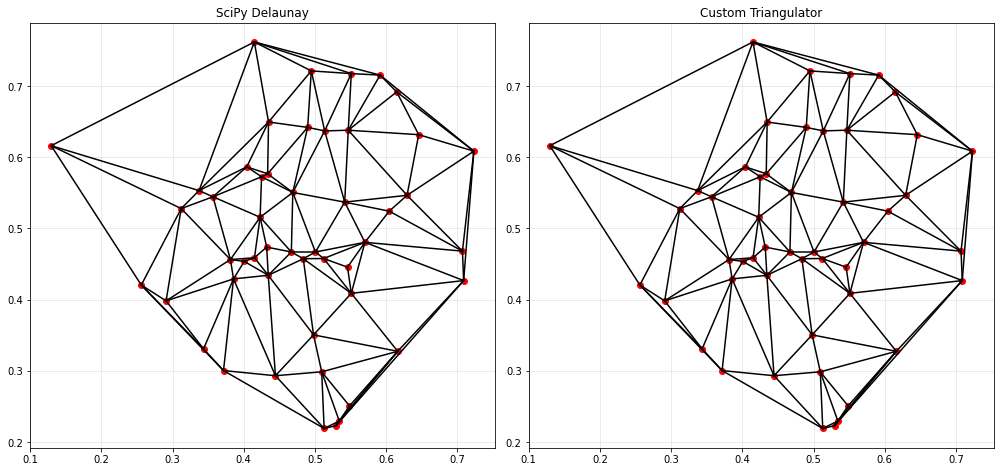

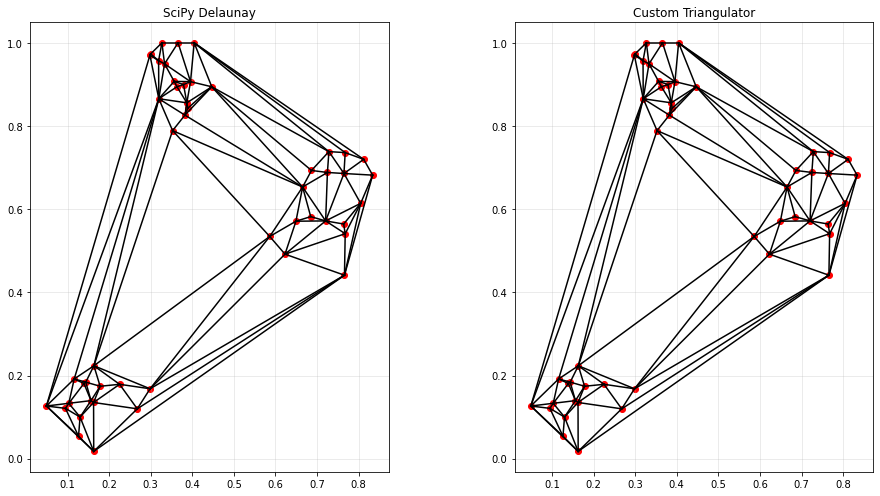

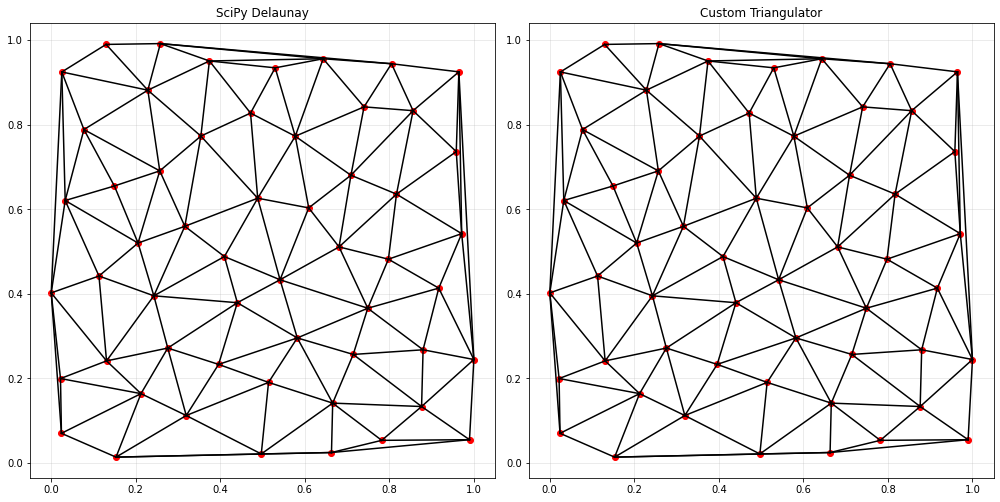

In [101]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay

def plot_triangulation_edges_side_by_side(
    points = generate_random_points(200, x_range=(0,100), y_range=(0,100), seed=10),
    triangulator = delaunay_triangulation
):
    """
    Plot SciPy Delaunay vs. custom triangulator side by side.
    points: list of (x, y)
    triangulator: function returning edges with .org and .dest as np.array([x,y])
    """

    points = np.array(points)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    tri_scipy = Delaunay(points)
    edges_scipy = set()
    for a, b, c in tri_scipy.simplices:
        edges_scipy.add(tuple(sorted((a, b))))
        edges_scipy.add(tuple(sorted((b, c))))
        edges_scipy.add(tuple(sorted((c, a))))

    for i, j in edges_scipy:
        x1, y1 = points[i]
        x2, y2 = points[j]
        axes[0].plot([x1, x2], [y1, y2], color="black")
    axes[0].scatter(points[:,0], points[:,1], color="red")
    axes[0].set_title("SciPy Delaunay")
    axes[0].set_aspect("equal")
    axes[0].grid(True, alpha=0.3)

 
    edges_custom = triangulator(points)
    seen = set()
    for e in edges_custom:
        a = tuple(e.org)
        b = tuple(e.dest)
        if a == b:
            continue
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        x1, y1 = a
        x2, y2 = b
        axes[1].plot([x1, x2], [y1, y2], color="black")

    axes[1].scatter(points[:,0], points[:,1], color="red")
    axes[1].set_title("Custom Triangulator")
    axes[1].set_aspect("equal")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

n_verify = 50
plot_triangulation_edges_side_by_side(points=generate_random_points(n_points=n_verify, seed=42),triangulator=delaunay_triangulation)
plot_triangulation_edges_side_by_side(points=generate_gaussian_points(n_points=n_verify, seed=42),triangulator=delaunay_triangulation)
plot_triangulation_edges_side_by_side(points=generate_clustered_points(n_points=n_verify, seed=42), triangulator=delaunay_triangulation)
r = np.sqrt(0.625 / n_verify) 
plot_triangulation_edges_side_by_side(points=generate_poisson_disc_points(radius=r, seed=42),triangulator=delaunay_triangulation)


## References:

1. Primitives for the Manipulation of General
Subdivisions and the Computation of Voronoi
Diagrams
LEONIDAS GUIBAS and JORGE STOLFI
Xerox Palo Alto Research Center and Stanford University 
(Printed Page 110, PDF Page 37, Section 9)

[http://www.sccg.sk/~samuelcik/dgs/quad_edge.pdf](http://www.sccg.sk/~samuelcik/dgs/quad_edge.pdf)